In [53]:
import pandas as pd
import numpy as np

In [54]:
# Data Load: Load banglore home prices into a dataframe

In [55]:
df1 = pd.read_csv("resources/bengaluru_house_prices.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [56]:
# get number of row and column

In [57]:
df1.shape


(13320, 9)

In [58]:
# get all columns
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [59]:
# drop column which is not required for prediction. We have dropped this column because a in generic model area_type and society
# society balcony and avaiability info might not always be present. also textual name does not add much significance
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(13320, 5)

In [60]:
# find nuber of null value in a column
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [61]:
# we can drop this column as we have bigger size of data so deleting some rows won't impact much 
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [62]:
# get shape after dropping 
df3.shape

(13246, 5)

In [63]:
# let start data formatting here we can see some of room mentioned as 
# bedroom and some as bhk so we will bring it down to smae fromat.
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

<ipython-input-63-5f638e55aad6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [64]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [65]:
df3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [66]:
# from above we can see some area has sqft in range. To handle them we will use mean of them 
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [67]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


In [68]:
# check now if total_sqft is smae format
df4.total_sqft.unique

<bound method Series.unique of 0        1056.0
1        2600.0
2        1440.0
3        1521.0
4        1200.0
          ...  
13315    3453.0
13316    3600.0
13317    1141.0
13318    4689.0
13319     550.0
Name: total_sqft, Length: 13200, dtype: float64>

In [69]:
# feature engineering
# we are going to create new column price_per_sqft. Here price is in lakh so converting to rupees
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [70]:
# Examine locations which is a categorical variable. We need to apply dimensionality 
# reduction technique here to reduce number of locations. 
# Hot encoding or dummy variable don't work well with categorical varibale with too many unique value
len(df5.location.unique())

1298

In [71]:
# let count number of property per locality. We are removing extra space before 
# and after location name just for precaution that two name should not be shown different just because of spaces.
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

Whitefield              533
Sarjapur  Road          392
Electronic City         304
Kanakpura Road          264
Thanisandra             235
                       ... 
Jogupalya                 1
Anathanagar               1
Halanayakanahalli         1
4th Block HBR Layout      1
Badrappa Layout           1
Name: location, Length: 1287, dtype: int64

In [72]:
location_stats.values.sum()

13200

In [73]:
len(location_stats[location_stats>10])

240

In [74]:
# Dimensionality Reduction
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Thyagaraja Nagar        10
Dairy Circle            10
Gunjur Palya            10
Sector 1 HSR Layout     10
Basapura                10
                        ..
Jogupalya                1
Anathanagar              1
Halanayakanahalli        1
4th Block HBR Layout     1
Badrappa Layout          1
Name: location, Length: 1047, dtype: int64

In [75]:
# total unique location before dimension reduction
len(df5.location.unique())

1287

In [76]:
# Any location having less than 10 data points should be tagged as "other" location. 
# This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, 
# it will help us with having fewer dummy columns

# total unique location after dimension reduction
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

241

In [77]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


In [78]:
# Outlier Removal Using Business Logic
# As a data scientist when you have a conversation with your business manager 
# (who has expertise in real estate), he will tell you that normally square ft 
# per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for 
# example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed 
# as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

# Check below data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. 
# These are clear data errors that can be removed safely

df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [79]:
# discard property whose area is less than 300
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12456, 7)

In [80]:
# Outlier Removal Using Standard Deviation and Mean
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [81]:
# Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide 
# variation in property prices. We should remove outliers per location 
# using mean and one standard deviation

In [82]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft) # mean
        st = np.std(subdf.price_per_sqft) # standard deviation
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))] # removing outlier per locality 
        df_out = pd.concat([df_out,reduced_df],ignore_index=True) # append cleaned data frame to empty data frame
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10242, 7)

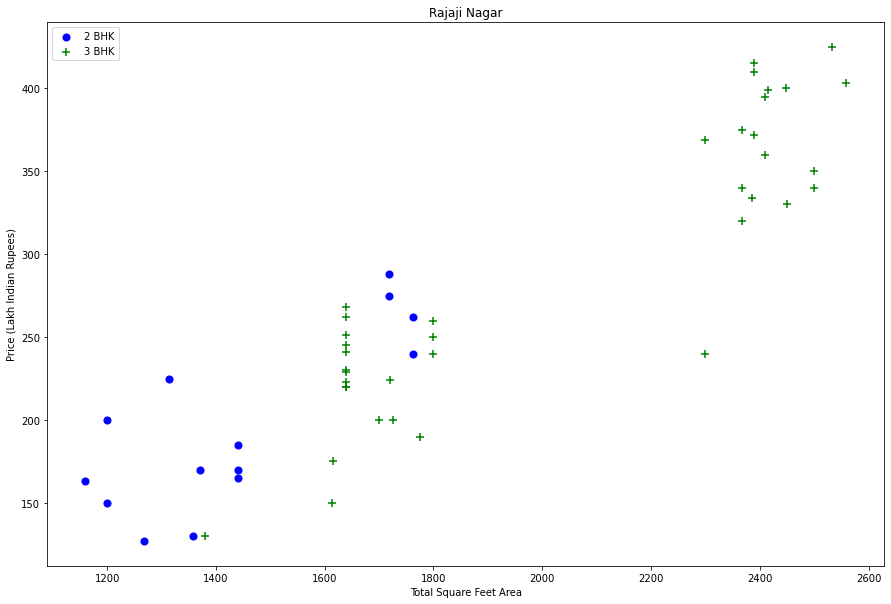

In [83]:
# Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like
import matplotlib
from matplotlib import pyplot as plt

def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

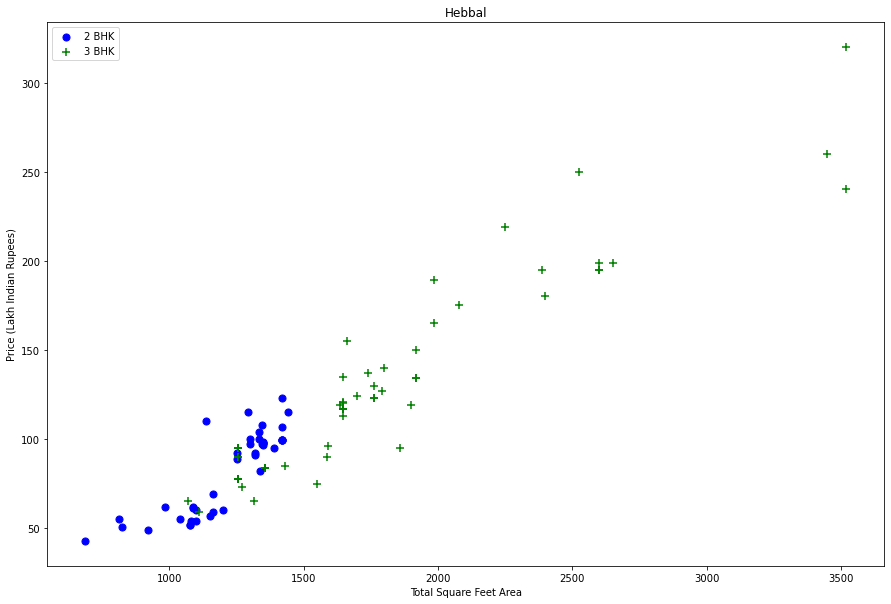

In [84]:
plot_scatter_chart(df7,"Hebbal")

In [85]:
# We should also remove properties where for same location, the price of (for example) 3 
# bedroom apartment is less than 2 bedroom apartment (with same square ft area).

# Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location_key, location_df_val in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df_val in location_df_val.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df_val.price_per_sqft),
                'std': np.std(bhk_df_val.price_per_sqft),
                'count': bhk_df_val.shape[0]
            }
        for bhk_key, bhk_df_val in location_df_val.groupby('bhk'):
            stats = bhk_stats.get(bhk_key-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df_val[bhk_df_val.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape # return a touple

(7317, 7)

In [86]:
# Outlier Removal Using Bathrooms Feature
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

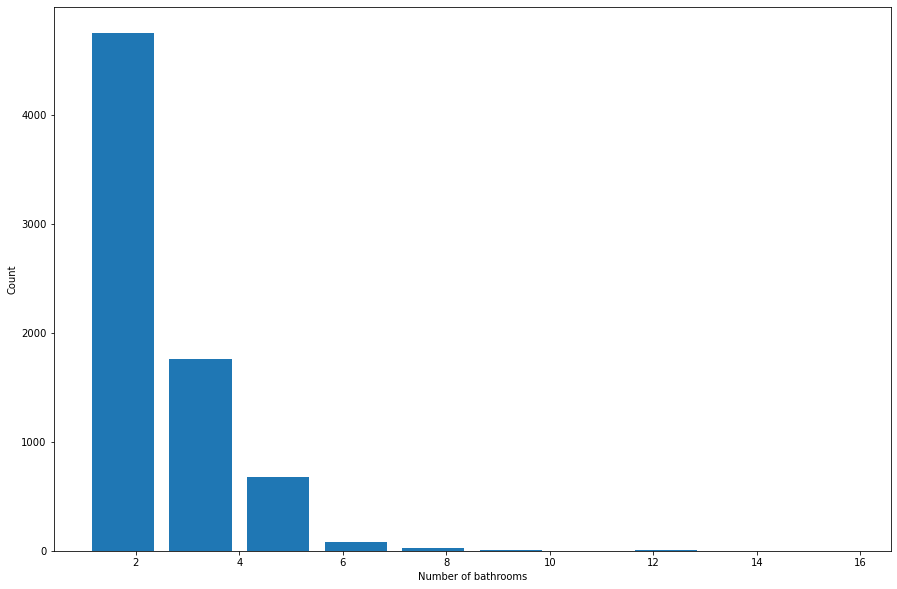

In [87]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [88]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


In [89]:
# It is unusual to have 2 more bathrooms than number of bedrooms in a home

df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [90]:
# Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom
# home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath =
# total bed + 1 max. Anything above that is an outlier or a data error and can be removed

df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7239, 7)

In [91]:
df9.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


In [92]:
# drop size and price_sqft column
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


In [93]:
# Use One Hot Encoding For Location

dummies = pd.get_dummies(df10.location)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
# drop other column

df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
# drop location column
df12 = df11.drop(['location'],axis='columns')
df12.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
# drop price column and assign rest to X for preparing training data
X = df12.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
X.shape

(7239, 243)

In [98]:
y = df12.price
y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [100]:
# length of target data
len(y)

7239

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)